<a href="https://colab.research.google.com/github/gennadygorin/GVP_2023/blob/main/gg221227_telegraph_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating regulated processes

Let's try to use PGFs to solve regulated systems.

Import relevant packages.

# Helper functions

In [1]:
import numpy as np
from numpy import matlib
import scipy.stats

import numba
import tqdm
import multiprocessing
import scipy
from scipy.fft import ifft, ifft2, ifftn, irfft, irfftn


import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import time
t1 = time.time()

## Simulation

In [2]:
@numba.njit
def update_rule(population, *args):
    '''
    Update rule that takes params and 
    updates the population matrix
    '''
    k_on, k_off, k, b1 = args
    m0, m1, m2 = population    
    flux =np.zeros(4)
    flux[0], flux[1], flux[2], flux[3] = k_on*(1-m0), k_off*m0, k*m0, b1*m1
    return flux
    
def sample_rxns(prob_arr):
    '''
    Takes prob_arr and
    returns an randomly sampled index according to 
    the probabilities specificed in prob_arr
    '''
    num = np.random.rand()
    sent = 0
    tot = 0.
    while tot < num:
        tot = tot + prob_arr[sent]
        sent = sent + 1
    return sent - 1

def step(calc_flux, population, t, *args):
    '''
    Takes flux calculating function, past event, 
    flux, population, t, args and
    returns time to reaction and the reaction that happens
    '''
    # print(args)
    flux = calc_flux( population, *args)[0]
    # print(flux)
    flux_sum = np.sum(flux)
    t = np.random.exponential(1. / flux_sum)
    rxn_prob = flux/flux_sum
    rxn = sample_rxns(rxn_prob)
    
    return rxn, t
def step_with_queued(calc_flux,population,t,queued_reactions,queued_reaction_times,export_arr,*args):
    '''
    Takes flux calculating function, past event, 
    flux, population, t, args and
    returns time to reaction and the reaction that happens
    '''
    # return step(calc_flux,population,t,*args)
    if len(queued_reactions)==0:
        return step(calc_flux,population,t,*args)
    else:
        # 
        population = np.copy(population)
        population_orig = np.copy(population)
        # queued_reactions = np.copy(queued_reactions)
        queued_reaction_times = np.copy(queued_reaction_times)

        init_flux = calc_flux( population, *args)[0]
        n_rxn = len(init_flux)
        fluxes = np.zeros((len(queued_reactions)+1,n_rxn))
        fluxes[0] = calc_flux( population, *args)[0]
        for q in range(len(queued_reactions)):
            population += export_arr[queued_reactions[q]]
            fluxes[q+1] = calc_flux( population, *args)[0]

        queued_reaction_times = np.concatenate(([t],queued_reaction_times))
        flux_sums = fluxes[:-1] * np.diff(queued_reaction_times)[:,None]
        flux_sums = np.concatenate((np.zeros(n_rxn)[None,:],flux_sums))
        flux_cumsums = np.cumsum(flux_sums,0)
        tot_flux_cumsum = flux_cumsums.sum(1)

        u = np.random.rand()
        flux = np.log(1/u)
        
        last_ind = np.where(tot_flux_cumsum<flux)[0][-1]
        dt = queued_reaction_times[last_ind]-t
        flux_orig = np.copy(flux)
        flux -= tot_flux_cumsum[last_ind]
        dtprime = flux/fluxes[last_ind].sum()
        dt += dtprime

        flux_sum = fluxes[last_ind]
        rxn_prob = flux_sum / flux_sum.sum()
        rxn = sample_rxns(rxn_prob)   
        return rxn, dt

def markovian_simulate(calc_flux, update, population_0, t_arr, tau, \
                       DELAYED_SPECIES_GENERATORS, export_arr,tau_list=None,\
                       return_full=False,*args):
    '''
    Takes params and
    returns matrix of the number of counts for 
    a species j at time t[i]
    '''
    if isinstance(tau , list) or isinstance(tau , tuple) :
        n_delays = len(tau)
    else:
        tau = [tau]
        n_delays = 1

    population_arr = np.zeros((len(t_arr), update.shape[1]))
    t = t_arr[0]
    population = population_0.copy()
    population_arr[0, :] = population
    t_list = []
    population_list = []
    rxn_list = []

    t_list.append(t)
    population_list.append(population)

    # Delay time queue
    if tau_list is None:
        tau_list = [[]]*n_delays
    tau_list_delay_inds = np.asarray(sum([[j]*len(x) for j,x in enumerate(tau_list)],[]))
    tau_list_all_delays = np.concatenate(tau_list)
    tau_list_sort = np.argsort(tau_list_all_delays).astype(int)

    tau_list_delay_inds = list(tau_list_delay_inds[tau_list_sort])
    tau_list_all_delays = list(tau_list_all_delays[tau_list_sort])
    
    while t < t_arr[-1]:
        event,dt = step_with_queued(calc_flux,population,t,\
                                    tau_list_delay_inds,tau_list_all_delays,\
                                    export_arr, *args)
        

        temp_t = t + dt
        
        # Check if an export event should slot in before t + dt
        while (len(tau_list_all_delays) != 0) and (temp_t > tau_list_all_delays[0]):
            population = population + export_arr[tau_list_delay_inds[0]]
            t = tau_list_all_delays[0]
            if t>t_arr[-1]:
                break
            t_list.append(t)
            population_list.append(population)
            rxn_list.append(-tau_list_delay_inds[0]-1)
            tau_list_all_delays.pop(0) # remove element
            tau_list_delay_inds.pop(0)

        if len(tau_list_all_delays)!=len(tau_list_delay_inds):
            raise ValueError
        
        # Perform event
        population = population + update[event, :]
        t = temp_t
        t_list.append(t)
        population_list.append(population)
        rxn_list.append(event)


        for j in range(n_delays):
            if event in DELAYED_SPECIES_GENERATORS[j]:
                tau_list_all_delays.append(t + tau[j])
                tau_list_delay_inds.append(j)
        tau_list_sort = np.argsort(tau_list_all_delays).astype(int)
        tau_list_delay_inds = list(np.asarray(tau_list_delay_inds)[tau_list_sort])
        tau_list_all_delays = list(np.asarray(tau_list_all_delays)[tau_list_sort])
    
    t_only_arr = np.asarray(t_list)
    population_list= np.asarray(population_list)
    for i in range(len(t_only_arr)):
        # print(t_only_arr)
        ind = np.searchsorted(t_arr, t_only_arr[i], side = 'right')
        # print(ind)
        population_arr[ind:] = np.array(population_list[i])
    if return_full:
        return population_arr,t_only_arr,population_list,rxn_list
    else:
        return population_arr

## Simulation setup 


In [3]:
def nondelay_wrapper_reg(N,n,K_val,A_val,beta_val,gamma_val,R_val,initcond,number_of_cells=5000,simulation_time=5,ndel=50):

    H,A,C,R,S,k,Hss = sim_setup_reg(N,n,K_val,A_val,beta_val,gamma_val,R_val)

    # print('sim set up.')
    # print(R)
    # print(S)
    # print(k)

    delayed_species = []
    DELAYED_SPECIES_GENERATORS = [[]]

    tau = []

    ####
    update_arr = S

    t_arr = np.linspace(0, simulation_time, ndel,endpoint=False)


    export_arr = np.zeros((len(delayed_species),N+n),dtype=int)


    samples = np.zeros((number_of_cells, len(t_arr), N+n))


    Hss = scipy.linalg.null_space(H.T)
    Hss /= Hss.sum()
    Hss = Hss.squeeze()

    for i in tqdm.tqdm(range(number_of_cells)):
        population_0 = np.zeros(N+n,dtype=int)
        if initcond[0][0]=='thermalized':
            init_state_prob = Hss
        elif isinstance(initcond[0][1],int):
            init_state_prob = np.zeros(N)
            jinit = initcond[0][1]
            init_state_prob[jinit] = 1
        else:
            init_state_prob = initcond[0][1]
        if N>1:
            population_0[:N] = np.random.multinomial(1,init_state_prob,1)
        else:
            population_0[:N] = 1
        initial_promoter_state = np.where(population_0[:N]==1)[0][0]

        for j,condition in enumerate(initcond[1:]):
            if isinstance(condition[0],str):
                if condition[0]=='deterministic':
                    population_0[j+N] = condition[1]
                elif condition[0]=='poisson':
                    population_0[j+N] = np.random.poisson(condition[1])
            else:
                if condition[initial_promoter_state][0]=='deterministic':
                    population_0[j+N] = condition[initial_promoter_state][1]
                elif condition[initial_promoter_state][0]=='poisson':
                    population_0[j+N] = np.random.poisson(condition[initial_promoter_state][1])
# # print('initcond')
            # if condition[0]=='deterministic':
            #     population_0[j+N] = condition[1]
            # elif condition[0]=='poisson':
            #     population_0[j+N] = np.random.poisson(condition[1])
        # print(population_0)
        # print(population_0.shape)
        # raise ValueError
        samples[i, :, :],event_t,event_x,_ = markovian_simulate(
            propfun_reg, update_arr, population_0, t_arr, \
            tau, DELAYED_SPECIES_GENERATORS, export_arr,[[]],\
            True,(k,K_val,A_val,beta_val,gamma_val,R_val,N))
    return t_arr,samples,H,A,C,R,init_state_prob

In [4]:
def sim_setup_reg(N,n,K_val,A_val,beta_val,gamma_val,R_val):
    #switching rates
    H = np.zeros((N,N))
    for kv in K_val:
        H[kv[0],kv[1]] = kv[2]
    H -= np.diag(H.sum(1))

    #synthesis rates
    A = np.zeros((N,n))
    for av in A_val:
        A[av[0],av[1]-1] = av[2]

    #splicing and degradation rates
    B = np.zeros((n,n))
    for bv in beta_val:
        B[bv[0]-1,bv[1]-1] = bv[2]
    B -= np.diag(B.sum(1))
    for gv in gamma_val:
        B[gv[0]-1,gv[0]-1] -= gv[1]
    
    #catalytic switching rates
    R = np.zeros((n,N,N))
    for rv in R_val:
        # print(rv)
        R[rv[0]-1,rv[1],rv[2]] = rv[3]
    for rna in range(n):
        R[rna,:,:] -= np.diag(R[rna,:,:,].sum(1))

    Nspec = N+n
    Nrxn = len(K_val) + len(A_val) + len(gamma_val) + len(beta_val) + len(R_val)
    S_mark = np.zeros((Nrxn,Nspec))
    k_mark = np.zeros(Nrxn)
    # reg_mark = np.zeros(len(R_val),dtype=int)

    i=0
    for kv in K_val:
        S_mark[i,kv[0]] = -1
        S_mark[i,kv[1]] = 1
        k_mark[i] = kv[2]
        i+=1

    for av in A_val:
        S_mark[i,av[1]+N-1] = 1
        k_mark[i] = av[2]
        i+=1
        
    for bv in beta_val:
        S_mark[i,bv[0]+N-1] = -1
        S_mark[i,bv[1]+N-1] = 1
        k_mark[i] = bv[2]
        i+=1
        
    for gv in gamma_val:
        S_mark[i,gv[0]+N-1] = -1    
        k_mark[i] = gv[1]
        i+=1

    for rv in R_val:
        S_mark[i,rv[1]] = -1
        S_mark[i,rv[2]] = 1
        k_mark[i] = rv[3]
        # reg_mark[i] = rv[0]
        i += 1

    Hss = scipy.linalg.null_space(H.T)
    Hss /= Hss.sum()
    Hss = Hss.squeeze()

    S_mark = S_mark.astype(int)

    return H,A,B,R,S_mark,k_mark,Hss
    # print(B)

def propfun_reg(x,*args):
    k,K_val,A_val,beta_val,gamma_val,R_val,N = args[0]
    # print(k)
    nRxn = len(k)
    # nCells = x.shape[0]
    nCells = 1

    a = np.zeros((nCells,nRxn),dtype=float)
    x = x.T
    a = a.T
    #######
    j = 0 

    # print(nCells)

    # print('hello')
    for i in range(len(K_val)):
        a[j] = k[j] * x[K_val[i][0]]
        # print(a[j])
        j+=1
    for i in range(len(A_val)):
        a[j] = k[j] * x[A_val[i][0]]
        j+=1
    for i in range(len(beta_val)):
        a[j] = k[j] * x[beta_val[i][0]+N-1]
        j+=1
    for i in range(len(gamma_val)):
        a[j] = k[j] * x[gamma_val[i][0]+N-1]
        j+=1
    for i in range(len(R_val)):
        a[j] = k[j] * x[R_val[i][0]+N-1] * x[R_val[i][1]]
        # print(a[j])
        # if a[j]<0:
        #     print(a)
        #     print(x)
        #     print(x[R_val[i][0]+N-1])
        #     print(k)
        #     print(k[j])
        #     raise ValueError
        j+=1
    # print(a)
    
    # print(a)
    # print(x)
    # raise ValueError
    return a.T

## PGF computation for generic non-delayed systems

In [5]:
def get_g(mx):
    u = []
    for i in range(len(mx)):
        l = np.arange(mx[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    return g


In [129]:
def pss_wrapper_reg(H,A,c10,r10,r01,t,mx,N,initcond):
    r=r10+r01
    # V = np.asarray([[0,-1],[r01,1]])
    # Vinv = np.asarray([[1/r01,1/r01],[-1,0]])
    V = np.asarray([[0,-1],[1,1]])
    Vinv = np.asarray([[1,1],[-1,0]])
    # V = np.asarray([[r10/r,-1],[r01/r,1]])
    # Vinv = np.asarray([[1,1],[-r01/r,r10/r]])
    # c23,c24,c30=k

    g = np.asarray(get_g(mx)).T
    ufun_specific = lambda s,g:  np.asarray([\
                    U1(s,g,c10),\
                    U2(s,g,r,c10)])
    # ufun_specific = lambda s,g:  np.asarray([\
    #                 U2(s,g,r,c10),\
    #                 U1(s,g,c10)])

    if initcond[0][0]=='thermalized':
        Hfin = scipy.linalg.null_space(H.T)
        Hfin /= Hfin.sum()
        w = Hfin.squeeze()
    elif initcond[0][0]=='deterministic':
        w = np.zeros(N)
        w[initcond[0][1]] = 1
    elif initcond[0][0]=='categorical':
        w = initcond[0][1]
    else:
        raise ValueError('Not implemented')
    w = np.asarray(w,dtype=np.complex128)

    gf_initcond_prop = np.ones((g.shape[0],N),dtype=np.complex128)

    for j,condition in enumerate(initcond[1:]):
        if isinstance(condition[0],str): #Identical conditions for all states
            if condition[0]=='deterministic':
                initcond_gfun = lambda x: (x+1)**condition[1]
            elif condition[0]=='poisson':
                initcond_gfun = lambda x: np.exp(condition[1]*x)
            for i in range(g.shape[0]):
                gf_initcond_prop[i,:] *= initcond_gfun(ufun_specific(t,g[i])[j])
        elif len(condition)==N: #list of length N
            for k in range(N):
                if condition[k][0]=='deterministic':
                    initcond_gfun = lambda x: (x+1)**condition[k][1]
                elif condition[k][0]=='poisson':
                    initcond_gfun = lambda x: np.exp(condition[k][1]*x)
                for i in range(g.shape[0]):
                    gf_initcond_prop[i,k] *= initcond_gfun(ufun_specific(t,g[i])[j])
        else: 
            print(N)
            print(len(condition[0]))
            raise ValueError
    # print(w)
    # print(Vinv)
    gf_initcond_prop *= w 
    # print(gf_initcond_prop)
    # gf_initcond_prop *= r10/r
    # print(Vinv)
    # raise ValueError
    gf_initcond_prop = np.dot(Vinv,gf_initcond_prop.T).T
    # print(gf_initcond_prop.T)
    # raise ValueError
    gf = gfun_specific(g,t,H,A,V,Vinv,r10,r01,N,ufun_specific,gf_initcond_prop)
    gf = np.dot(V,gf.T).T

    # gf = np.dot(V,gf.T).T
    Pss = np.zeros((max(mx),N))
    for j in range(N):
        Pss[:,j] = np.real(ifft(gf[:,j]))
    return Pss.squeeze()


In [121]:
def gfun_specific(g,t,H,A,V,Vinv,r10,r01,N,ufun_specific,gf_initcond):
    gf_ = np.zeros((g.shape[0],N),dtype=np.complex128)
    
    for i in (range(g.shape[0])):
        t0 = 0
        y0 = gf_initcond[i]
        
        Ufun = lambda x:  ufun_specific(x,g[i])
        intfun = lambda t,y: intfun_multi(t,y,H,A,V,Vinv,r10,r01,Ufun)
        res = scipy.integrate.solve_ivp(intfun,[t,t0],y0,method='DOP853')
        while res.status == 'running':
            res.step()
        gf_[i] = res.y[:,-1]
    return gf_

def intfun_multi(t,y,H,A,V,Vinv,r10,r01,Ufun):
    """
    CHANGE THE UFUN ARGUMENT HERE
    """


    # print(Ufun(t))
    # raise ValueError
    # dy = np.dot(H.T,y) + A[0,0]*Ufun(t)[0]*y
    # dy = np.dot(H.T,y) + A[0,0]*Ufun(t)*y
    # print(A)
    # print(Ufun(t))
    # dy = np.dot(H.T,y) + np.dot(A,[Ufun(t)[1]])*y
    U_ = Ufun(t)
    a = A[0][0]
    k01 = -H[0][0]
    k10 = -H[1][1]
    r = r10 + r01
    r0 = r10/r
    r1 = r01/r
    k = k01+k10
    wd = (k01*r10-k10*r01)/r
    A_ = np.asarray([[0, a*U_[0]],[k10, -a*U_[1]+k]])
    # A_ = np.asarray([[0, a*U_[0]/r01],[k10*r01, -a*U_[1]+k]])
    # A_ = np.asarray([[-a*U_[0]*r0, a*U_[0]],[a*r0*r1*U_[1]-wd, -a*r1*U_[1]+k]])
    # print(y.shape)
    # print(A_.shape)
    dy = np.dot(A_,y)
    # print(dy)
    # dy = np.dot(H.T,y) + np.dot(A,[Ufun(t)[1]])*y 
    # print(np.dot(A,[Ufun(t)[0]])) #Obviously this works for 

    # print((A*Ufun(t)[0]).T*y)
    # print(y)
    # raise ValueError
    # dy = np.dot(H.T,y) + np.dot(A,Ufun(t)[0])*y
    return dy


In [10]:
# r10

In [11]:
# H

In [112]:
def U1(s,g,c10):
    return g[0] * np.exp(-c10*s)
def U2(s,g,r,c10):
    r_ = r + c10
    return 1/r_ * (np.exp(-r_*s) * (r + r_*g[0]) - r)

## Visualization for generic non-delayed systems

In [13]:
conditional_colors = ('red','cadetblue','deeppink','khaki')
uncond_colors = ('lightgray','darkgray')
alf=0.5

In [123]:
def viz_nondelay(t_arr,samples,N,n,H,A,c10,r10,r01,initcond,init_state_prob,focus=None):
    nt=5
    fig1,ax1=plt.subplots(nt,n+1,figsize=(12,12))
    for k,tind in enumerate([0,2,5,10,49]):
        t=t_arr[tind]

        X=samples[:,tind,:]
        ax1[k,0].bar(np.arange(N),X[:,:N].mean(0),color=conditional_colors,alpha=alf)

        Pss_gene = np.dot(scipy.linalg.expm(t*H.T),init_state_prob)
        ax1[k,0].plot(Pss_gene,'r-')
        
        mx = [1]*n
        Pss_gene = pss_wrapper_reg(H,A,c10,r10,r01,t,mx,N,initcond)
        ax1[k,0].plot(Pss_gene,'b--')
        print('pgf')
        print(Pss_gene)

        Pss_gene_off = A__*(C__*scipy.special.hyp1f1(alf__-1, bet__-1, fd*Q__) - \
                            scipy.special.hyp1f1(alf__, bet__, fd*Q__))#huang
        Pss_gene = np.asarray([1-Pss_gene_off,Pss_gene_off])
        print('huang')
        print(Pss_gene)
        ax1[k,0].plot(Pss_gene,'g:',linewidth=2)

        ax1[k,0].set_xticks([])
        ax1[k,0].set_yticks([])
        ax1[k,0].set_ylabel('t = {:.2f}'.format(t))
        for i in range(n):
            mx = [1]*n

            ub = X[:,N+i].max() + 5
            mx[i] = int(ub)
            Pss = pss_wrapper_reg(H,A,c10,r10,r01,t,mx,N,initcond)
            if focus is None:
                for j in range(N):
                    # print('start')
                    # print(i)
                    # print(j)
                    cf = X[:,j]==1
                    
                    bins = np.arange(ub)-0.5
                    hist,_ = np.histogram(X[cf,N+i],bins,density=True)
                    ax1[k,i+1].bar(bins[:-1]+0.5,hist*Pss_gene[j],color=conditional_colors[j],alpha=alf)
                    # MU = (Pss[:,j]/Pss_gene[j]*np.arange(mx[i])).sum()
                    # print(MU)
                    # VAR = (Pss[:,j]/Pss_gene[j]*(np.arange(mx[i])-MU)**2).sum()
                    # print(VAR)
                    ax1[k,i+1].plot(Pss[:,j],color=conditional_colors[j],alpha=alf)
            else:
                j=focus
                cf = X[:,j]==1
                
                bins = np.arange(ub)-0.5
                hist,_ = np.histogram(X[cf,N+i],bins,density=True)
                ax1[k,i+1].bar(bins[:-1]+0.5,hist*Pss_gene[j],color=conditional_colors[j],alpha=alf)
                ax1[k,i+1].plot(Pss[:,j],color=conditional_colors[j],alpha=alf)

            # bins = np.arange(X[:,N+i].max()+6)-0.5
            # hist,_ = np.histogram(X[:,N+i],bins,density=True)
            # ax1[k,i+1].bar(bins[:-1]+0.5,hist,color=uncond_colors[0],alpha=alf)

            # ax1[k,i+1].plot(Pss.sum(1),color=uncond_colors[1])


            ax1[k,i+1].set_xticks([])
            ax1[k,i+1].set_yticks([])
    fig1.tight_layout()
    # return Pss

In [15]:
conditional_colors

('red', 'cadetblue', 'deeppink', 'khaki')

# Scenarios

Here, we consider systems in order of increasing complexity, and compare their solutions to simulations. "Homogeneous" means the system starts at zero molecules. "Thermalized" means its initial distribution over gene states is the steady state.

In [ ]:
k_on = .75
k_off = .5

N = 2
K_val = [[0,1,k_off],
         [1,0,k_on]]

n = 1
A_val =[[0,1,10]]
    
gamma_val = [[1,3.14]]
beta_val = []

R_val = []
# R_val = [[1,0,1,10]]

## 2-state, 2-species, homogeneous thermalized

In [ ]:
initcond = [['deterministic',0],
            ['deterministic',0]]
t_arr,samples,H,A,C,R,init_state_prob = nondelay_wrapper_reg(N,n,K_val,A_val,beta_val,gamma_val,R_val,initcond,number_of_cells=10000)

100%|██████████| 10000/10000 [00:34<00:00, 286.80it/s]


In [ ]:
c10 = gamma_val[0][-1]
r10 = 1e-9
# r01 = R_val[0][-1]
r01=1e-9

/usr/local/lib/python3.8/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


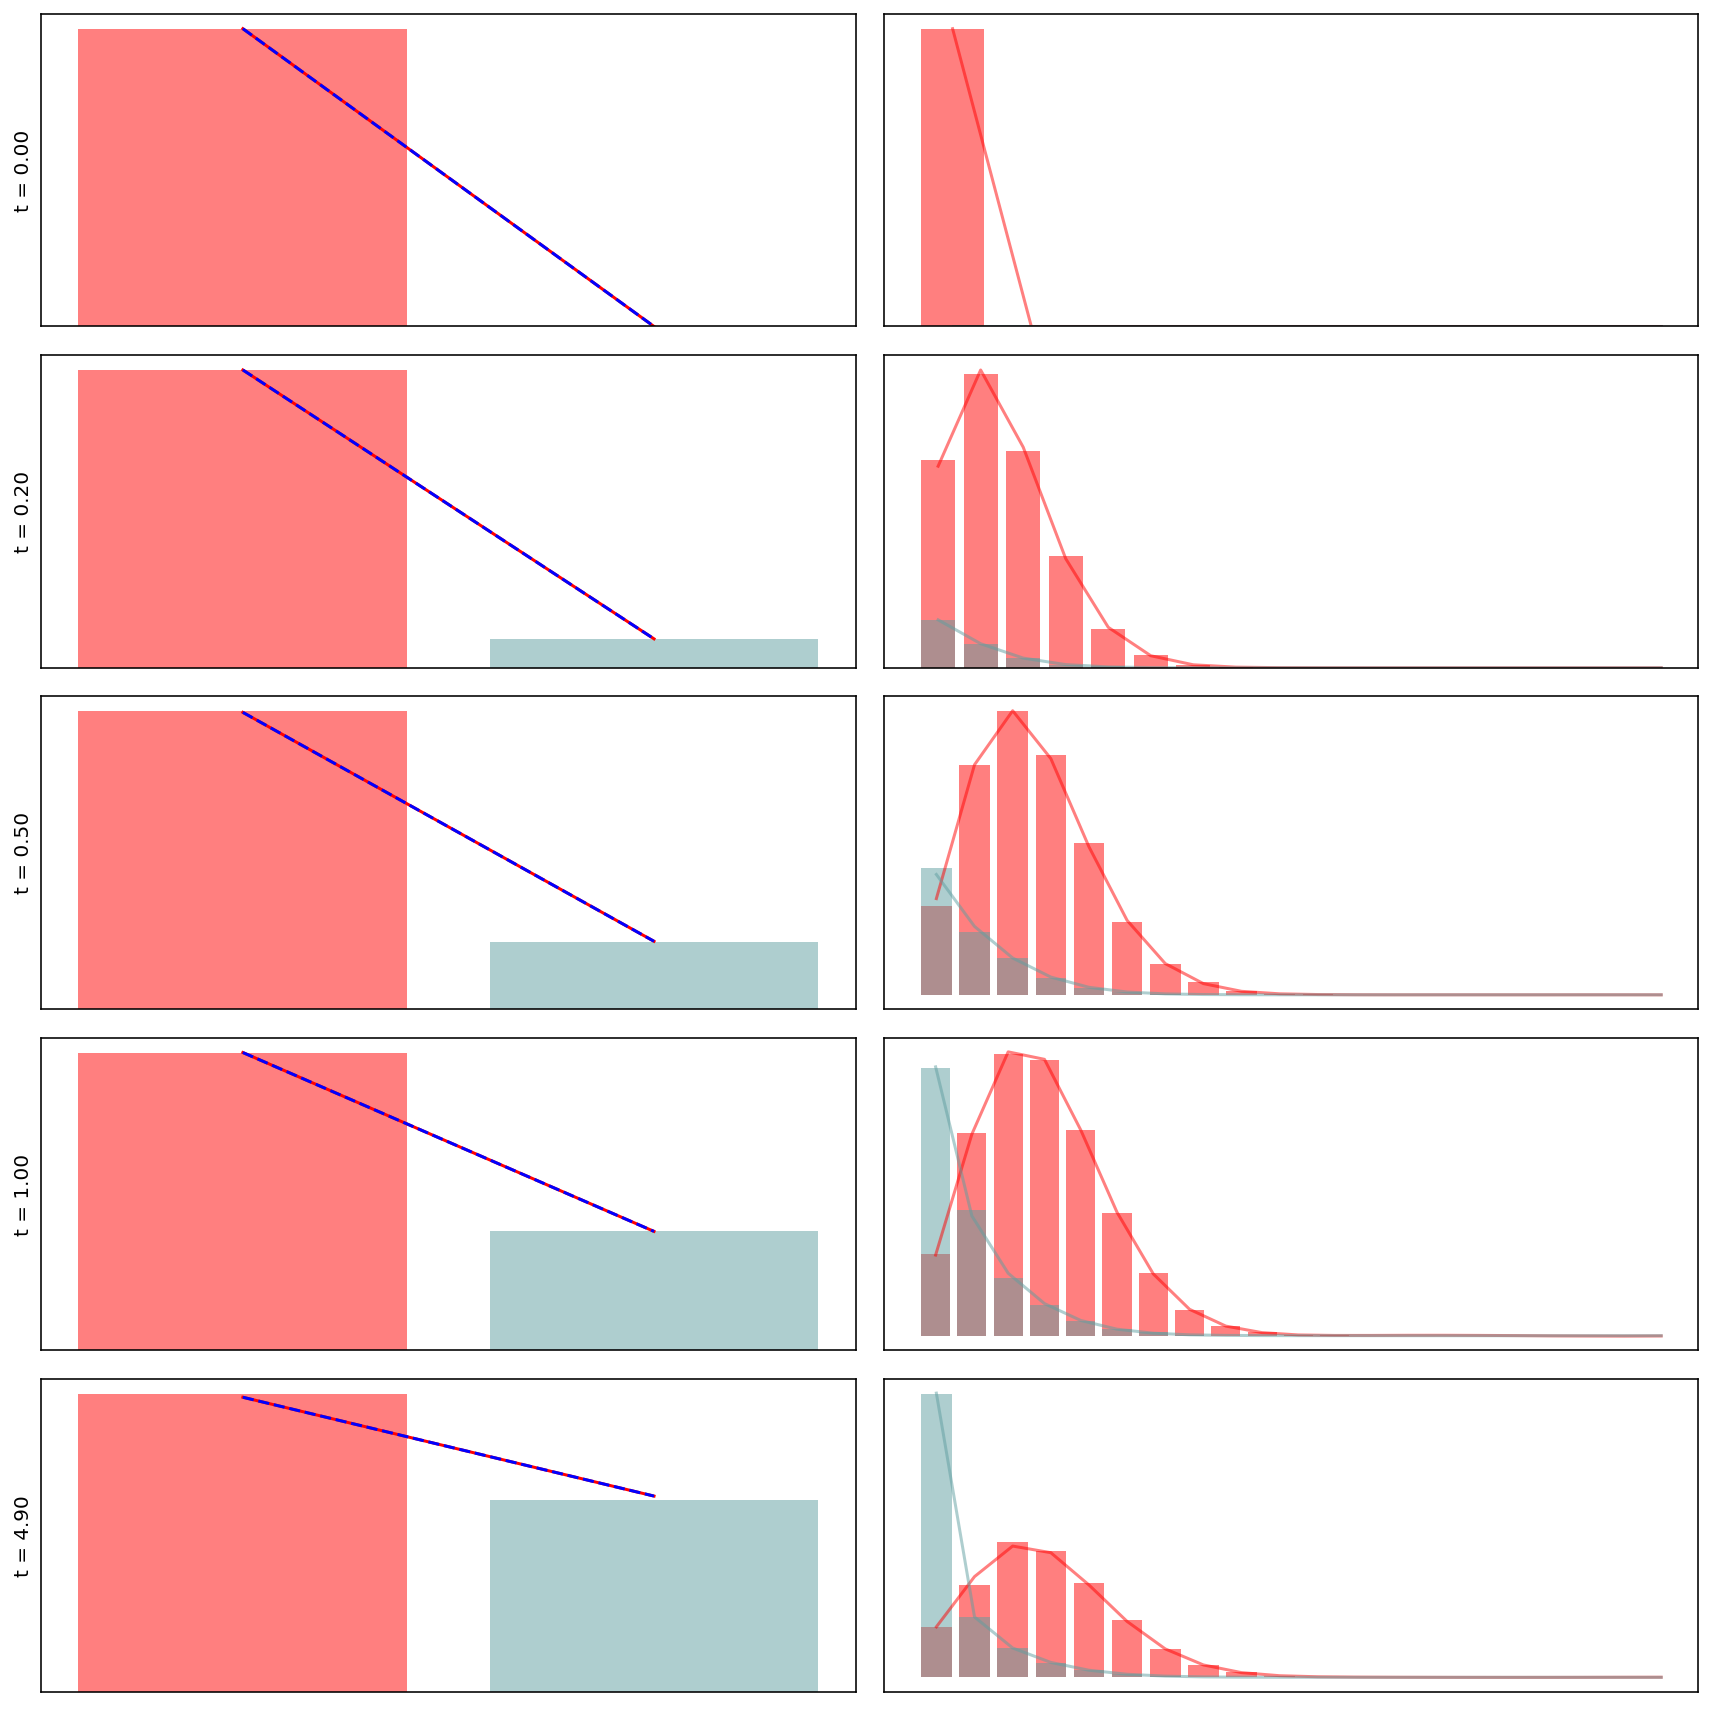

In [ ]:
viz_nondelay(t_arr,samples,N,n,H,A,c10,r10,r01,initcond,init_state_prob)

## With regulation

In [16]:
k_on = 0.4
k_off = 0.05

N = 2
K_val = [[0,1,k_off],
         [1,0,k_on]]

n = 1
A_val =[[0,1,10]]
    
gamma_val = [[1,0.1]]
beta_val = []

# R_val = []
R_val = [[1,0,1,10]]

In [17]:
# initcond = [['thermalized'],
#             ['deterministic',0]]
initcond = [['deterministic',0],
            ['deterministic',0]]
t_arr,samples,H,A,C,R,init_state_prob = \
nondelay_wrapper_reg(N,n,K_val,A_val,beta_val,gamma_val,R_val,initcond,number_of_cells=5000,simulation_time=100)

100%|██████████| 5000/5000 [00:33<00:00, 147.78it/s]


In [18]:
t_arr

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
       26., 28., 30., 32., 34., 36., 38., 40., 42., 44., 46., 48., 50.,
       52., 54., 56., 58., 60., 62., 64., 66., 68., 70., 72., 74., 76.,
       78., 80., 82., 84., 86., 88., 90., 92., 94., 96., 98.])

In [19]:
c10 = gamma_val[0][-1]
r10 = 0
r01 = R_val[0][-1]
# r01=1e-9

Using both in somewhat of an ugly way

In [20]:
X = samples[:,-1,2]

In [30]:
X.mean()

2.1366

In [21]:
X.var()/X.mean()

0.7134421229991575

In [34]:
# A__ = 
# C__ = 
gamma_ = k_off / c10
lambda_ = k_on / c10
fd = r01 / c10
dMU = A[0][0] / c10
R__ = dMU
Q__ = R__/(fd+1)**2
C__ = (dMU + gamma_ + lambda_)/lambda_ - R__/(lambda_*(fd+1))
alf__ = 1 + lambda_*dMU/R__
bet__ = 1 + ((dMU+lambda_+gamma_)/(fd+1)) - R__/(fd+1)**2
A__ = 1/(C__ * scipy.special.hyp1f1(alf__-1, bet__-1, fd*Q__))

In [38]:
mean_analytical = A__ * (dMU * scipy.special.hyp1f1(alf__, bet__, fd*Q__))

In [56]:
D__ = (dMU*(dMU*lambda_+R__)*(fd+1))/((fd+1)*(dMU+lambda_+gamma_+fd+1)-R__)

In [58]:
Gpp_analytical  = A__*D__*scipy.special.hyp1f1(alf__+1, bet__+1, fd*Q__)

In [59]:
var_analytical = Gpp_analytical + mean_analytical - mean_analytical**2

In [60]:
var_analytical

1.52299574271954

In [61]:
D__*A__

0.6626413468684353

In [62]:
scipy.special.hyp1f1(alf__+1, bet__+1, fd*Q__)

5.892329833918801

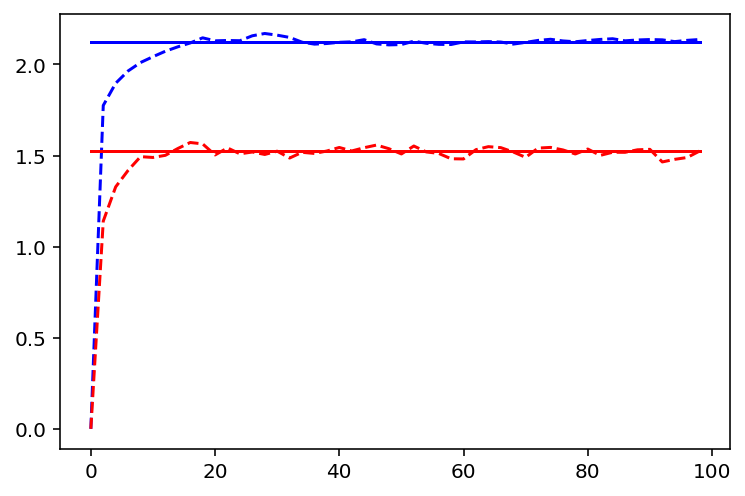

In [64]:
plt.plot(t_arr,samples[:,:,2].mean(0),'b--')
plt.plot(t_arr,np.ones_like(t_arr)*(mean_analytical),'b-')
plt.plot(t_arr,samples[:,:,2].var(0),'r--')
plt.plot(t_arr,np.ones_like(t_arr)*(var_analytical),'r-')


The solid solution is from Huang. The simulation is correct: mean and variance match analytical solution.

Left side shows state probabilities. 

* Red: ignore regulation, just exponentiate $H^T$.
* Blue: Add up the probabilities from the ODE solution.
* Green: Use Huang solution at steady state.

pgf
[1. 0.]
huang
[0.02122192 0.97877808]
pgf
[0.06523597 0.93476403]
huang
[0.02122192 0.97877808]
pgf
[0.06523764 0.93476236]
huang
[0.02122192 0.97877808]
pgf
[0.06523894 0.93476106]
huang
[0.02122192 0.97877808]
pgf
[0.06525198 0.93474802]
huang
[0.02122192 0.97877808]


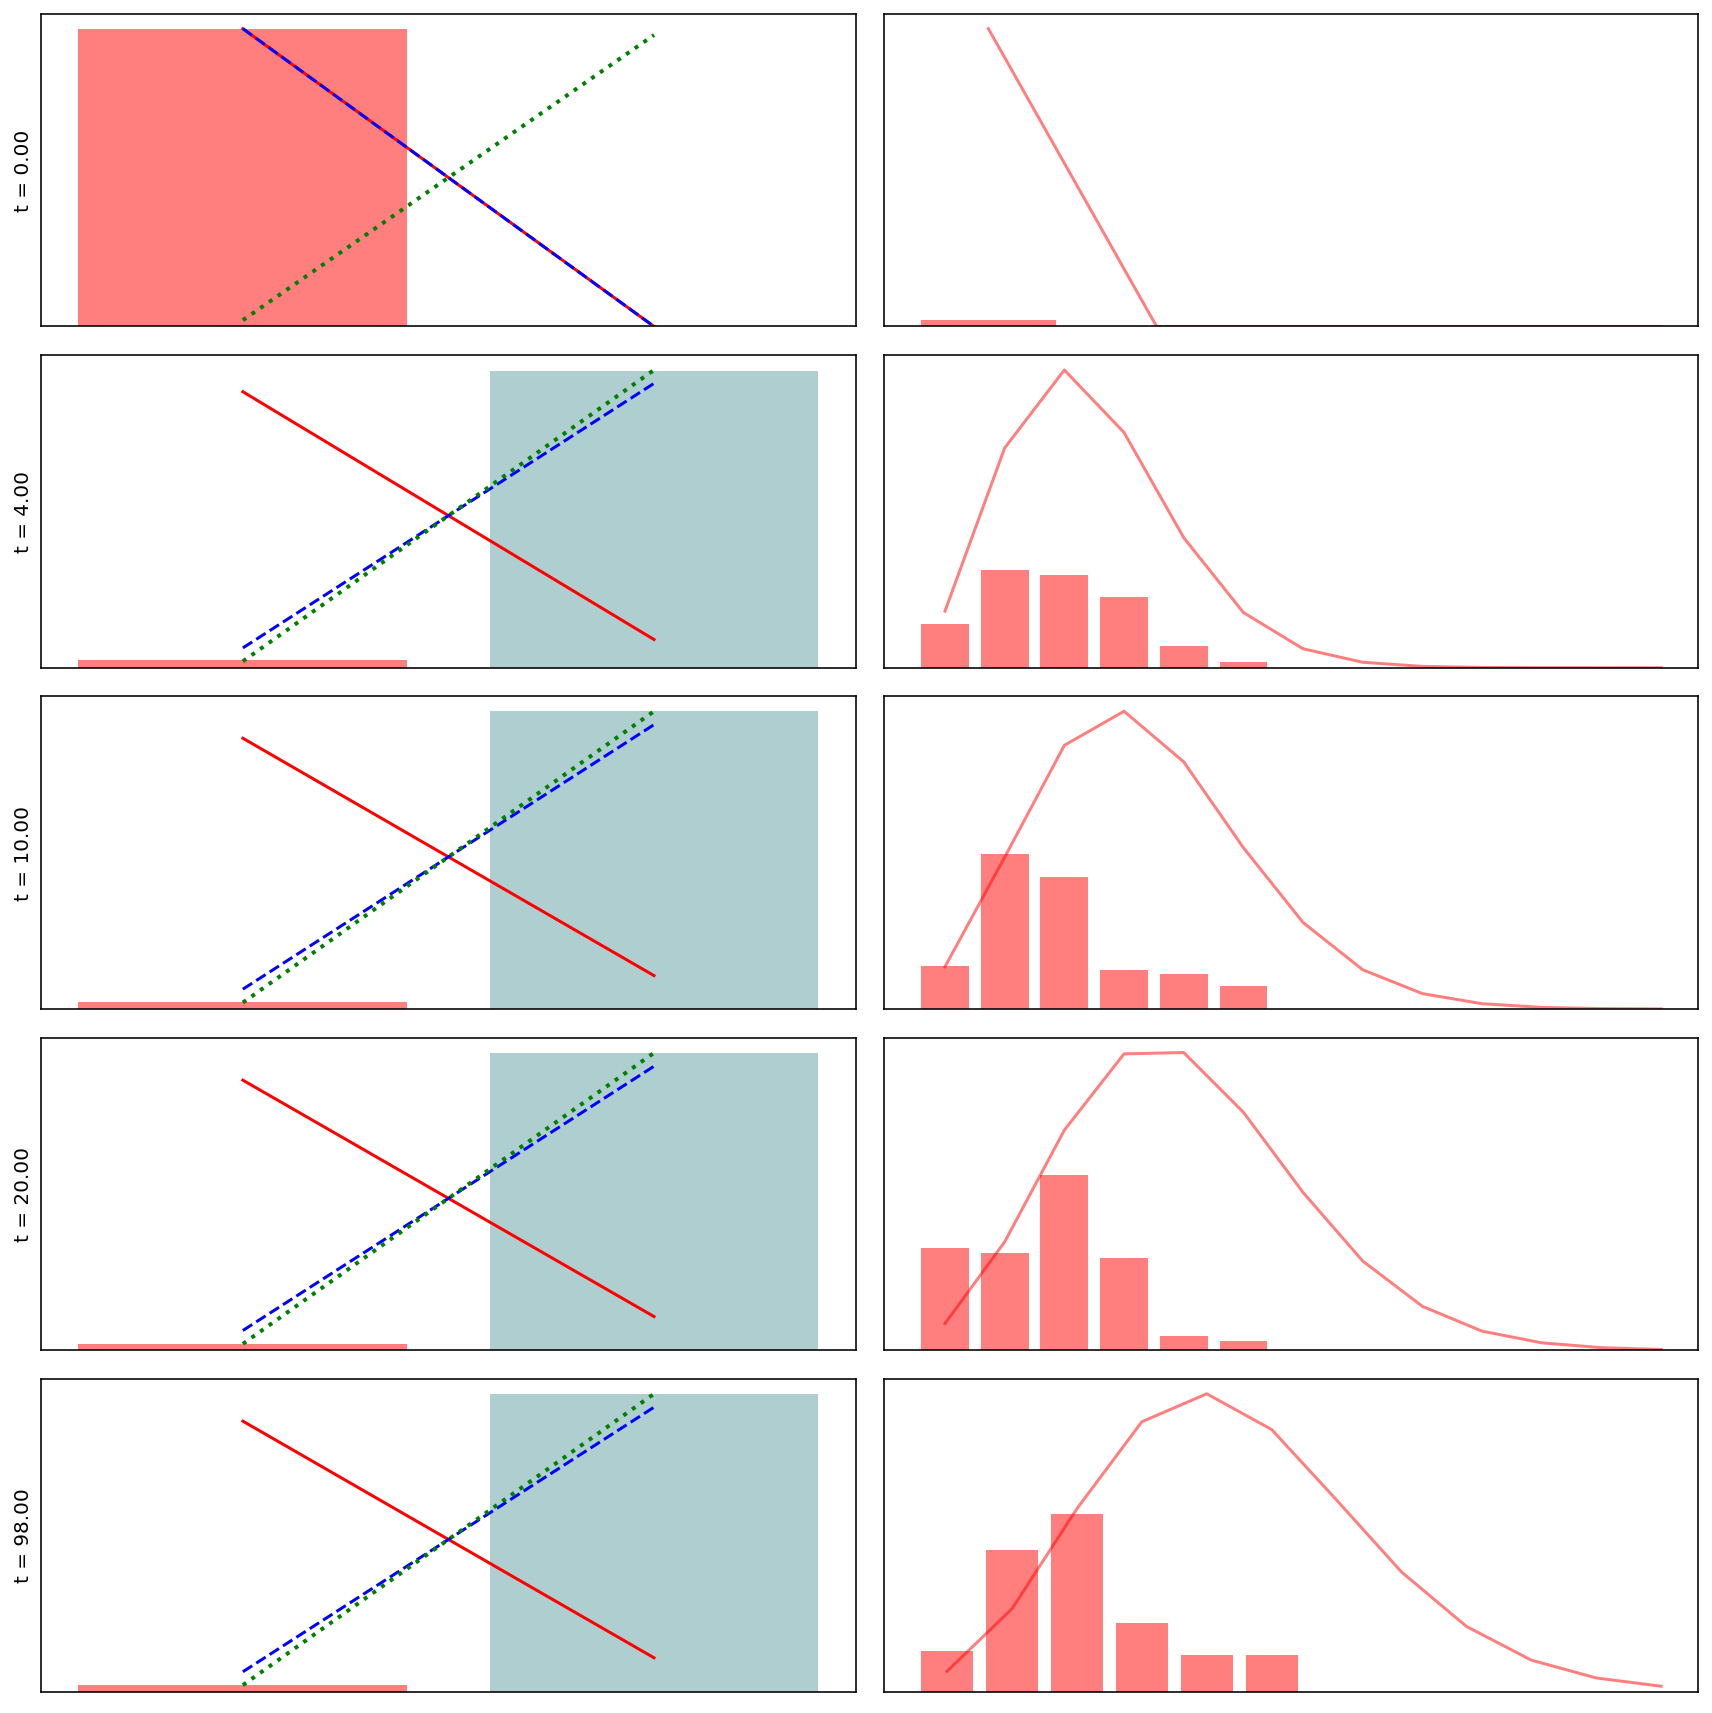

In [130]:
viz_nondelay(t_arr,samples,N,n,H,A,c10,r10,r01,initcond,init_state_prob,focus=0)

pgf
[1. 0.]
huang
[0.02122192 0.97877808]
pgf
[0.06523597 0.93476403]
huang
[0.02122192 0.97877808]
pgf
[0.06523764 0.93476236]
huang
[0.02122192 0.97877808]


/usr/local/lib/python3.8/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


pgf
[0.06523894 0.93476106]
huang
[0.02122192 0.97877808]
pgf
[0.06525198 0.93474802]
huang
[0.02122192 0.97877808]


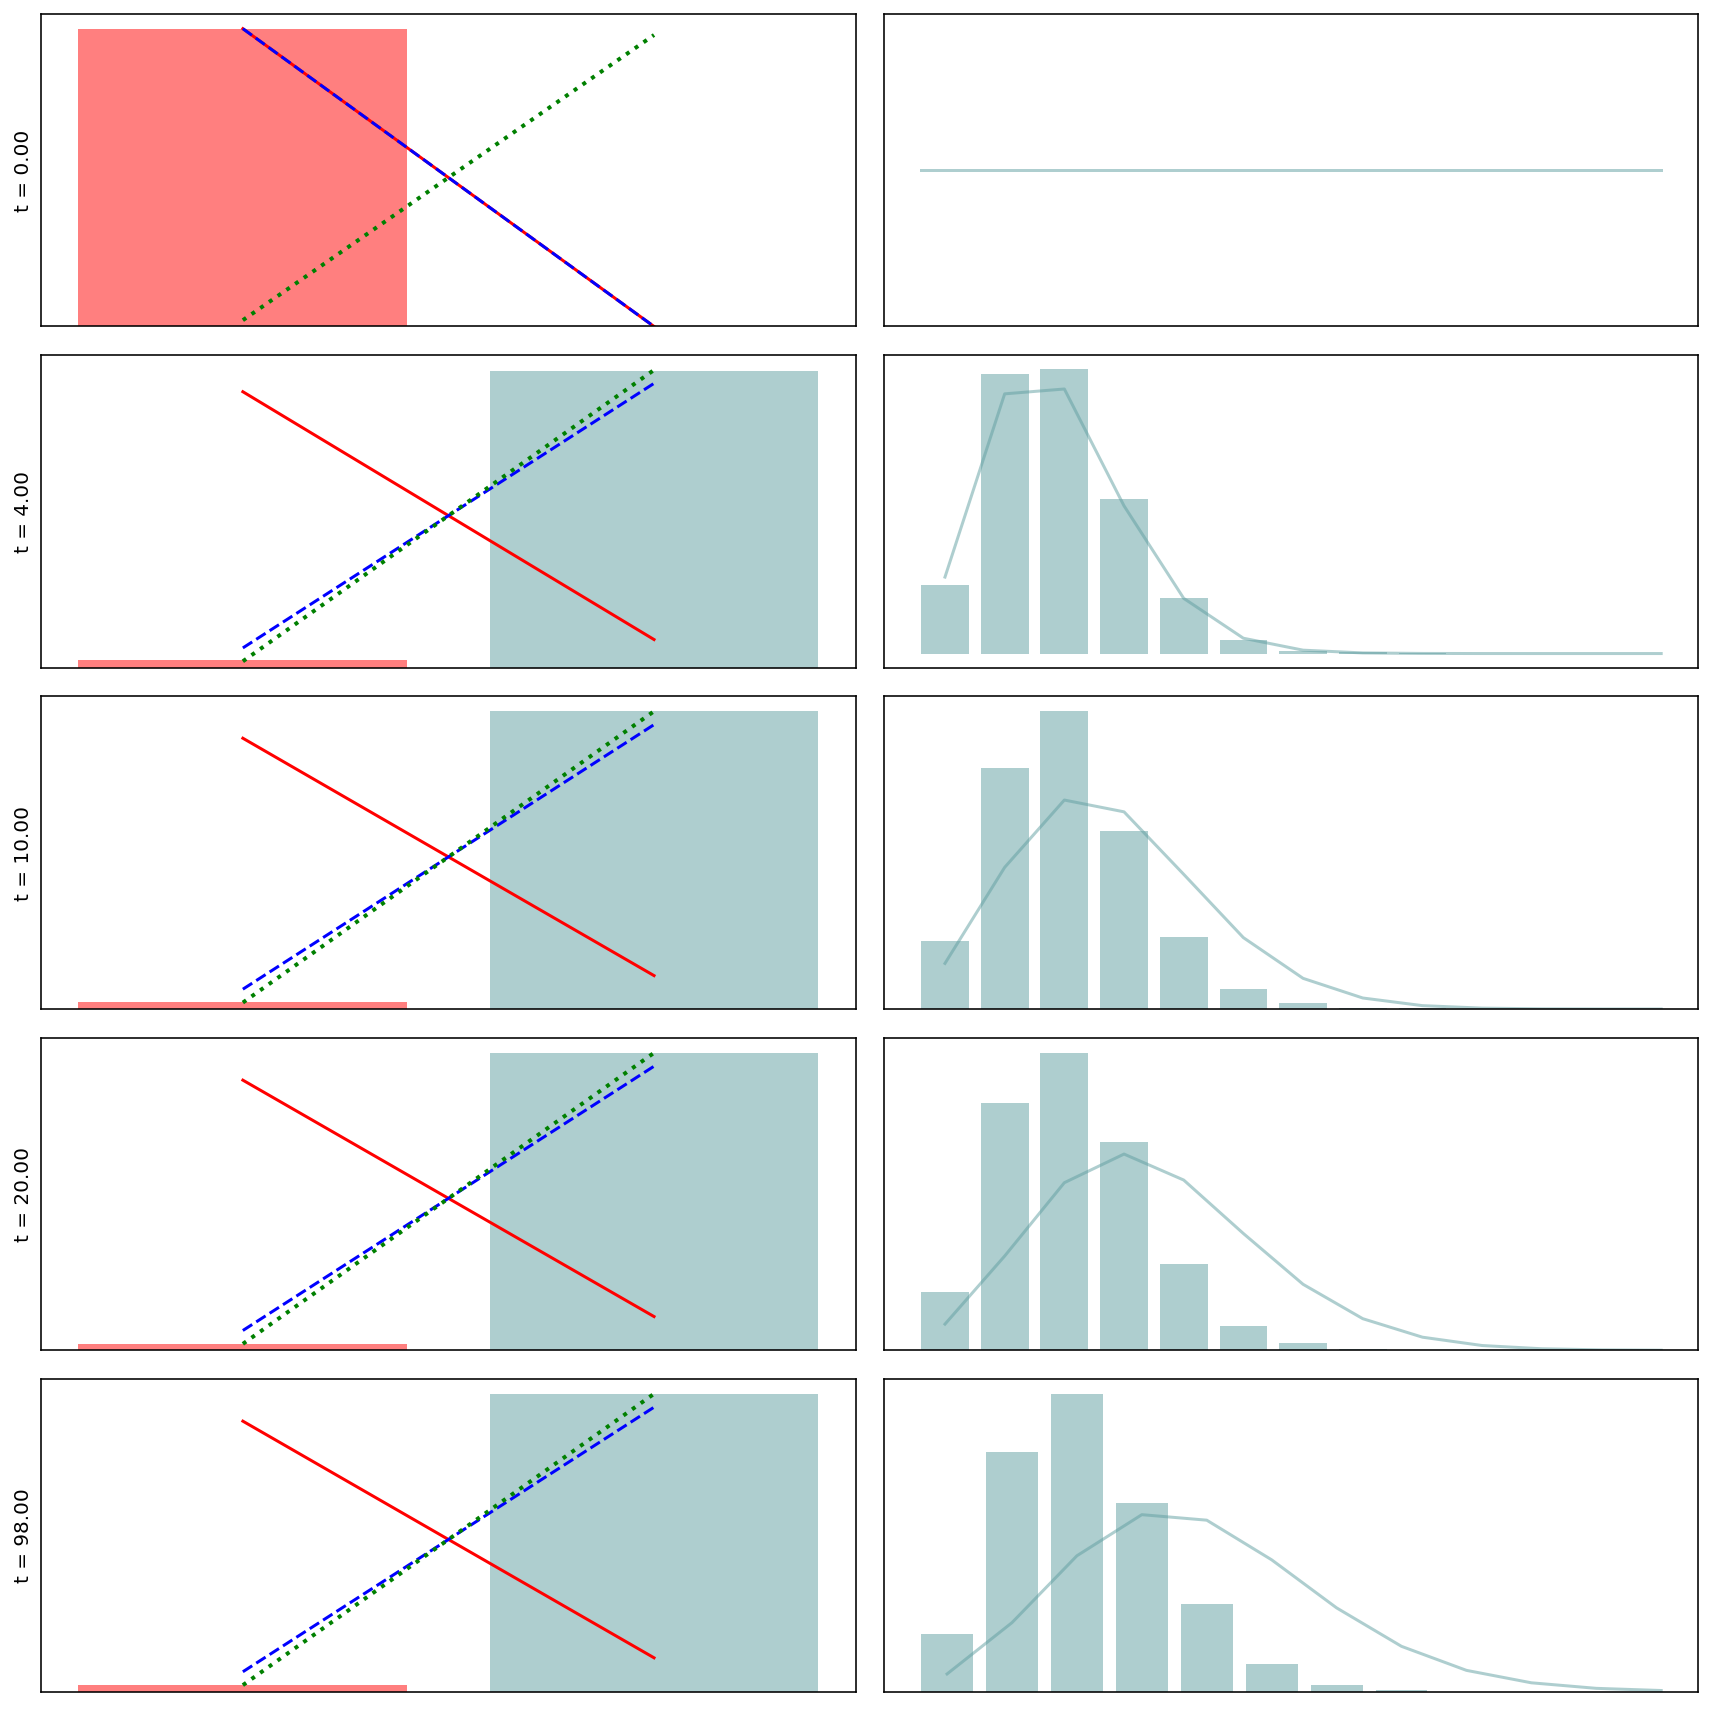

In [131]:
viz_nondelay(t_arr,samples,N,n,H,A,c10,r10,r01,initcond,init_state_prob,focus=1)

pgf
[1. 0.]
huang
[0.02122192 0.97877808]
pgf
[0.06523597 0.93476403]
huang
[0.02122192 0.97877808]


/usr/local/lib/python3.8/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


pgf
[0.06523764 0.93476236]
huang
[0.02122192 0.97877808]
pgf
[0.06523894 0.93476106]
huang
[0.02122192 0.97877808]
pgf
[0.06525198 0.93474802]
huang
[0.02122192 0.97877808]


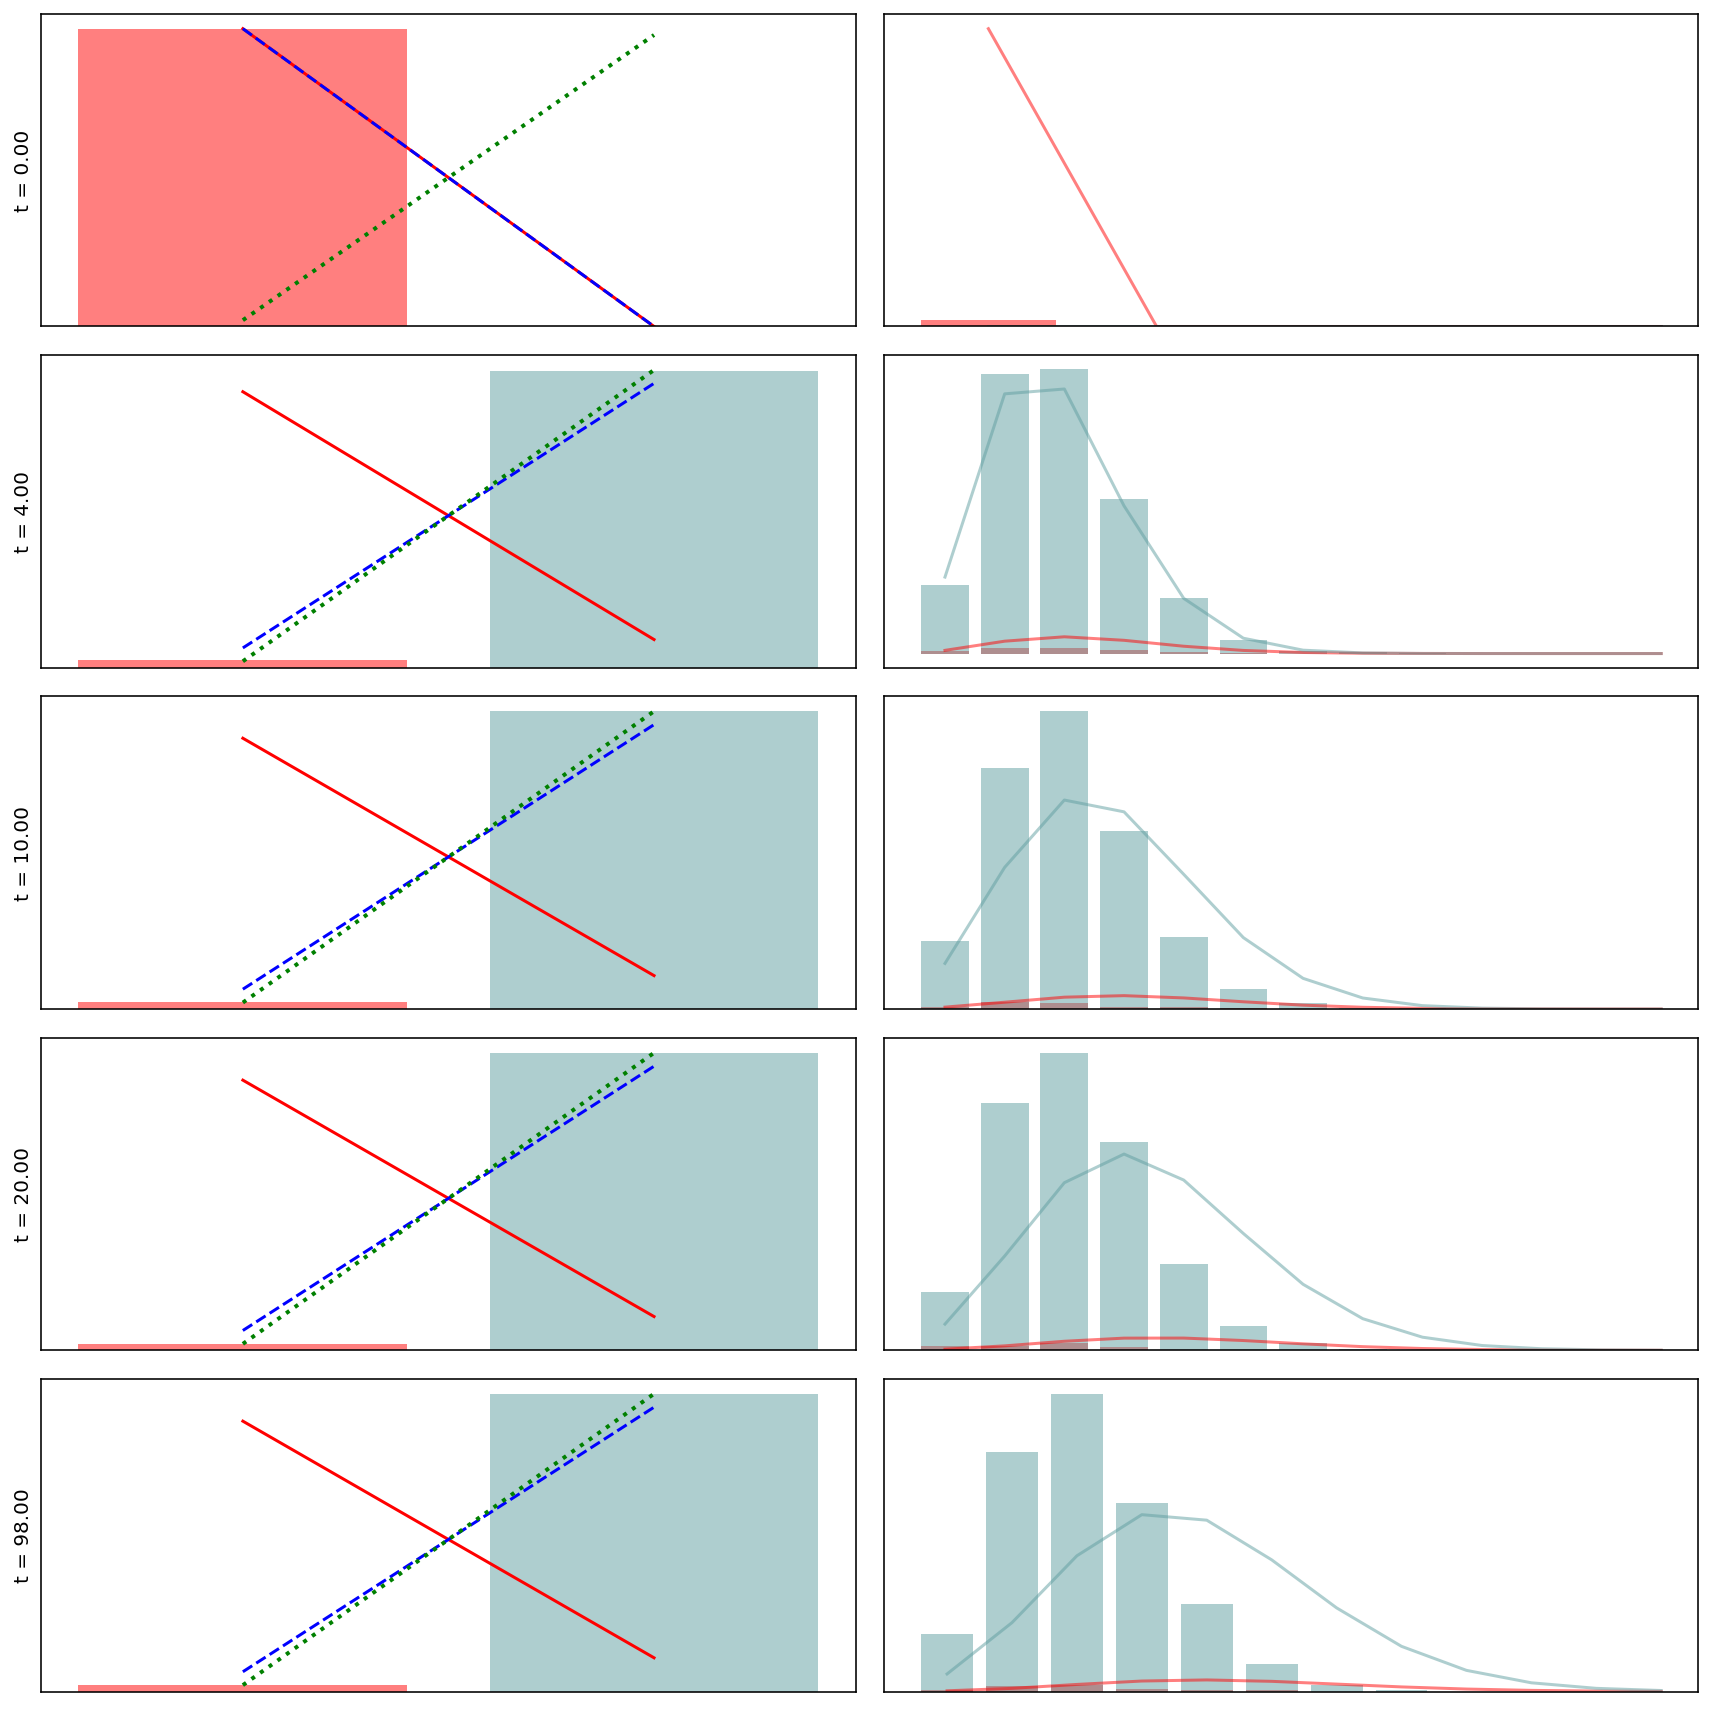

In [132]:
viz_nondelay(t_arr,samples,N,n,H,A,c10,r10,r01,initcond,init_state_prob)

HMMMMMMMMMM

The dynamics are obviously wrong, and this example also gives the wrong steady state. The state probabilities are part of the way there...